<a href="https://colab.research.google.com/github/mmaruthi/Deep_Learning_EVA4_Phase1/blob/master/Session9/Cifarquiz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime 
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-03-21 19:03:28.197938


In [0]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
!git clone https://github.com/mmaruthi/Deep_Learning_EVA4_Phase1
%cd Deep_Learning_EVA4_Phase1/Session9
! ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/project_folder'
/content/gdrive/My Drive/project_folder
Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 839 (delta 18), reused 1 (delta 1), pack-reused 794
Receiving objects: 100% (839/839), 4.35 MiB | 2.59 MiB/s, done.
Resolving deltas: 100% (518/518), done.
/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/Session9
models	readme.txt


In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
#from torchviz import make_dot
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from models import Alb_data_transforms,Model,QuizDNN,Dataloaders,Train_losses,Testlosses,Gradcam

Below section of code is to get the mean and stdev of train data which will be used for normalization while applying transforms. **No need to execute this everytime** we run the file

In [0]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
batchsize = 128
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

batches = int(i/batchsize)
mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, '\n'
      'No: Of Batches:', batches, '\n'
      'Channels Mean:',mu, '\n'
      'Channels Stdev:',std, '\n'
      'Channels squared sum mean:', sq/n, '\n'
      'Total Pixles (N):', n)

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



No: Of Train Images: 50000 
No: Of Batches: 390 
Channels Mean: [0.49139968 0.48215841 0.44653091] 
Channels Stdev: [0.24703223 0.24348513 0.26158784] 
Channels squared sum mean: [0.30249857 0.29176174 0.26781806] 
Total Pixles (N): 51200000


In [0]:
# 0.4.5 is the latest albumentation version
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 13.0MB/s 
     |████████████████████████████████| 634kB 25.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=c5c98a747c4af9be39d51a0418a89824af52d0bc192d858b3e073ff2d7d1d0a4
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=f7b03f769f8bf375087888c71b497db3a863ca24eb6ad245cf677b7c841ffa2f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
import albumentations as A

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-15.0, 15.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.IAAAdditiveGaussianNoise(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=1,max_h_size=8,max_w_size=8) 
                                                                  # fillvalue for cutout= default i.e. 0 as after normalizing mean is 0
                                                                  # size as 8 i.e. 25% of 32x32 CIFAR 10 data
                                                                  
                                                                 ])

train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

Files already downloaded and verified
Files already downloaded and verified


## Below section of code is to display train images from training set



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

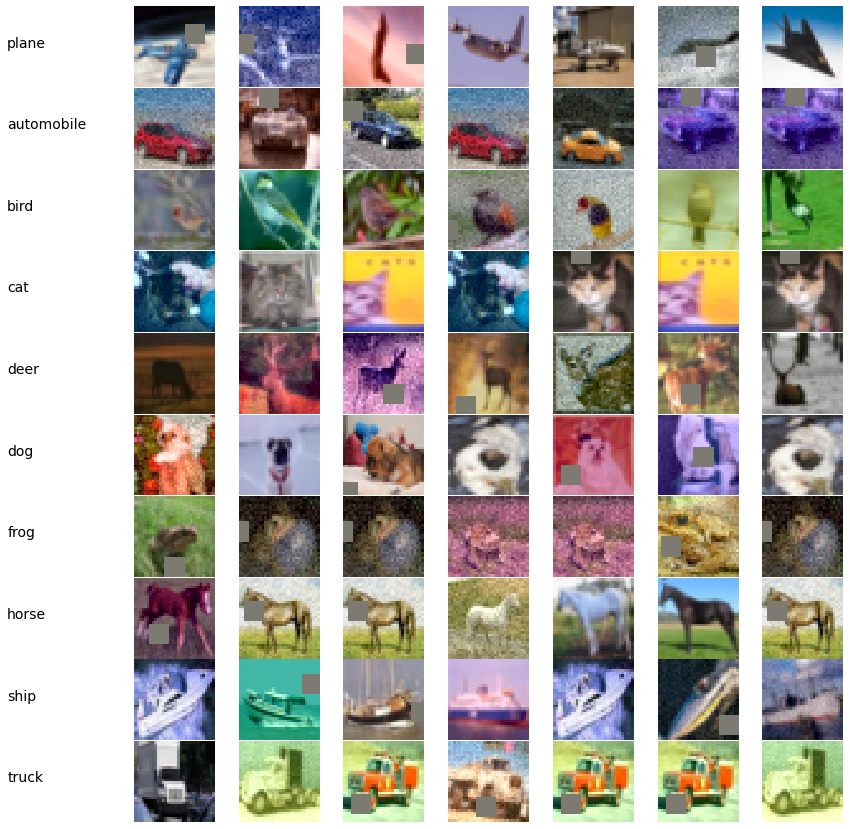

In [0]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)

# Function to unnormalize and bring back to original pixel values. Transpose is to reshape the image on x & y axes and make it ready for display

def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))


dataiter = iter(trainloader)
images, labels = dataiter.next()

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)  ## Selecting 7 random images for each class
    ax = plt.subplot(row, col,class_num*col+1)                             ## Laying out space for display of a particular class
    ax.text(-0.1, 0.5, class_names[class_num], fontsize=14)                ## Displaying class names
    plt.axis('off')
    for j in range(1, num_images+1):                                       ## Displaying images one-by-one for a particular class
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [0]:
!pip install torchsummary
from torchsummary import summary
model = QuizDNN.CIFAR10Net_S9()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
             ReLU-11           [-1, 64, 16, 16]               0
      BatchNorm2d-12           [-1, 64, 16, 16]             128
          Dropout-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [0]:
train_loss = Train_losses.Train_loss()
test_loss  = Testlosses.Test_loss()

# Train and Test the model 

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

EPOCH     = 20
L2_factor = 0.0001
L1_factor = 0.0005
OPTIMIZER = optim.SGD(model.parameters(), lr=0.025, momentum=0.9, nesterov=True, weight_decay=L2_factor)
SCHEDULER = OneCycleLR(OPTIMIZER, max_lr=0.2, steps_per_epoch=len(trainloader), epochs=EPOCH)
train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []

for epoch in range(EPOCH):

    print("EPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,model.device,train_loader=trainloader,optimizer=OPTIMIZER,
                                                         epoch=EPOCH,factor=L1_factor,scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
    test_losses, test_acc   = test_loss.test_loss_calc(model,model.device,test_loader=testloader)

    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Train Loss = 1.1618692874908447 Batch Id = 390 Train Accuracy = 45.77 Learning Rate = 0.020872: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1582, Test Accuracy: 58.94

EPOCH: 1


Train Loss = 0.980421781539917 Batch Id = 390 Train Accuracy = 61.04 Learning Rate = 0.056037: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9699, Test Accuracy: 64.96

EPOCH: 2


Train Loss = 0.737017035484314 Batch Id = 390 Train Accuracy = 67.41 Learning Rate = 0.104064: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8639, Test Accuracy: 71.27

EPOCH: 3


Train Loss = 0.9732146263122559 Batch Id = 390 Train Accuracy = 70.72 Learning Rate = 0.152074: 100%|██████████| 391/391 [00:53<00:00,  7.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7413, Test Accuracy: 74.38

EPOCH: 4


Train Loss = 0.6824569702148438 Batch Id = 390 Train Accuracy = 73.30 Learning Rate = 0.187192: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8328, Test Accuracy: 72.44

EPOCH: 5


Train Loss = 0.730432391166687 Batch Id = 390 Train Accuracy = 74.81 Learning Rate = 0.200000: 100%|██████████| 391/391 [00:52<00:00,  7.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6442, Test Accuracy: 77.49

EPOCH: 6


Train Loss = 0.672906756401062 Batch Id = 390 Train Accuracy = 76.34 Learning Rate = 0.197480: 100%|██████████| 391/391 [00:52<00:00,  7.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5911, Test Accuracy: 79.97

EPOCH: 7


Train Loss = 0.6409212350845337 Batch Id = 390 Train Accuracy = 77.66 Learning Rate = 0.190072: 100%|██████████| 391/391 [00:53<00:00,  7.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6022, Test Accuracy: 79.27

EPOCH: 8


Train Loss = 0.48464033007621765 Batch Id = 390 Train Accuracy = 78.39 Learning Rate = 0.178147: 100%|██████████| 391/391 [00:53<00:00,  7.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6037, Test Accuracy: 80.04

EPOCH: 9


Train Loss = 0.6635327339172363 Batch Id = 390 Train Accuracy = 79.40 Learning Rate = 0.162304: 100%|██████████| 391/391 [00:53<00:00,  7.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Test Accuracy: 80.72

EPOCH: 10


Train Loss = 0.5181021690368652 Batch Id = 390 Train Accuracy = 80.06 Learning Rate = 0.143337: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5270, Test Accuracy: 81.95

EPOCH: 11


Train Loss = 0.5527086853981018 Batch Id = 390 Train Accuracy = 80.88 Learning Rate = 0.122196: 100%|██████████| 391/391 [00:53<00:00,  7.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4901, Test Accuracy: 83.29

EPOCH: 12


Train Loss = 0.5314756631851196 Batch Id = 390 Train Accuracy = 81.54 Learning Rate = 0.099943: 100%|██████████| 391/391 [00:52<00:00,  7.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4839, Test Accuracy: 83.19

EPOCH: 13


Train Loss = 0.5255186557769775 Batch Id = 390 Train Accuracy = 82.33 Learning Rate = 0.077692: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4907, Test Accuracy: 83.29

EPOCH: 14


Train Loss = 0.5212824940681458 Batch Id = 390 Train Accuracy = 83.25 Learning Rate = 0.056560: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4417, Test Accuracy: 85.06

EPOCH: 15


Train Loss = 0.5118001699447632 Batch Id = 390 Train Accuracy = 84.50 Learning Rate = 0.037607: 100%|██████████| 391/391 [00:52<00:00,  7.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4046, Test Accuracy: 86.15

EPOCH: 16


Train Loss = 0.3818959891796112 Batch Id = 390 Train Accuracy = 85.68 Learning Rate = 0.021782: 100%|██████████| 391/391 [00:52<00:00,  7.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3759, Test Accuracy: 87.19

EPOCH: 17


Train Loss = 0.3244134485721588 Batch Id = 390 Train Accuracy = 86.65 Learning Rate = 0.009879: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3603, Test Accuracy: 87.74

EPOCH: 18


Train Loss = 0.19334229826927185 Batch Id = 390 Train Accuracy = 87.44 Learning Rate = 0.002495: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3479, Test Accuracy: 88.30

EPOCH: 19


Train Loss = 0.3841557800769806 Batch Id = 390 Train Accuracy = 88.18 Learning Rate = 0.000001: 100%|██████████| 391/391 [00:53<00:00,  7.33it/s]



Test set: Average loss: 0.3482, Test Accuracy: 88.33



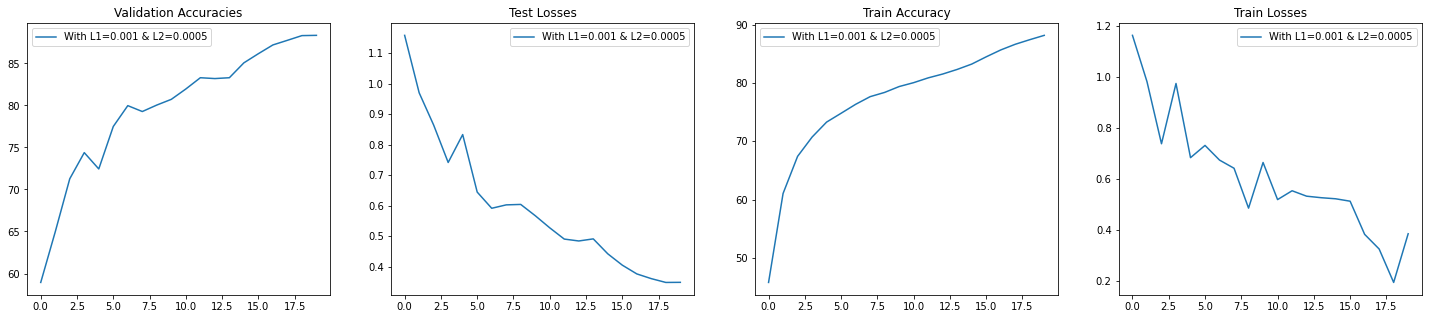

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Validation Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    